<h1 style="text-align: center;">Semantic Segmentation - Neural Network</h1>
<h3 style="text-align: center;">Carlos Moreno</h3>

In [3]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
from PIL import Image
import numpy as np



Run device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4070 SUPER


# ->Load Dataset

Mitocondría Dataset

In [3]:
def Set_tif_Dataset(path, width= 512, height= 512):
    images_list = []

    with Image.open(path) as img:
        try:
            while True:
                # Convert each page to an RGB image
                img_rgb = img.convert("L")

                # Resize to the desired dimensions
                img_resized = img_rgb.resize((width, height))

                # Convert to a NumPy array and normalize pixel values to [0, 255]
                img_array = np.array(img_resized)/255.0

                # Add to the list
                images_list.append(img_array)

                # Move to the next page
                img.seek(img.tell() + 1)
        except EOFError:
            pass  # End of the TIFF file
    return np.stack(images_list[:200])

In [139]:
def Set_jpg_Dataset(abs_path, rotation = False, target_size= (256, 256)):
    csv_path = os.path.join(abs_path, 'train.csv')
    data = pd.read_csv(csv_path)[:200]

    image_dir = os.path.join(abs_path,'images/', 'images/')
    mask_dir =  os.path.join(abs_path,'masks/', 'masks/' ) 
    images_dict = defaultdict(list)
    masks_dict = defaultdict(list)
    
    start_time = time.time()
    i = 0

    with tqdm(total=len(data), desc="Img-mask upload", dynamic_ncols=True, leave=True) as pbar:

        for _, row in data.iterrows():
                image_name = row['ImageId']
                mask_name = row['MaskId']
    
                #patient ID
                patient_id = image_name.split('_')[0]
    
    
                angle = random.uniform(0, 180) if rotation else 0
    
                # Load and process the image
                image = Image.open(os.path.join(image_dir, image_name)).convert("L")
                image = image.rotate(angle)
                image = np.array(image.resize(target_size)) / 255.0
    
                mask = Image.open(os.path.join(mask_dir, mask_name)).convert("RGB")
                mask = mask.rotate(angle)
                mask = np.array(mask.resize(target_size)) / 255.0
                
                threshold = 0.2  # Adjust as needed              
                mask = (mask[:, :, 2] > threshold) * mask[:, :, 2]

                images_dict[patient_id].append(image)
                masks_dict[patient_id] .append(mask)
    
                # Update progress bar
                pbar.update(1)
    
                i = i + 1
    
                elapsed_time = time.time() - start_time
                remaining_steps = len(data) - pbar.n
                time_per_step = elapsed_time / pbar.n if pbar.n > 0 else 0
                estimated_time_left = time_per_step * remaining_steps
    
    
    
                # Set progress bar postfix with estimated time left
                pbar.set_postfix({
                    "N_Img": f"{i}",
                    "Estimated Time Left": f"{int(estimated_time_left // 60)}m {int(estimated_time_left % 60)}s"
                })

    # Randomly split patient IDs into training and testing sets
    patient_ids = list(images_dict.keys())
    #random.shuffle(patient_ids)
    
    split_index = len(patient_ids) // 2
    train_ids = patient_ids[:split_index]
    test_ids = patient_ids[split_index:]
    
    # Create training and testing datasets as NumPy arrays
    train_images = np.array([img for pid in train_ids for img in images_dict[pid]])
    train_masks = np.array([mask for pid in train_ids for mask in masks_dict[pid]])
    
    test_images = np.array([img for pid in test_ids for img in images_dict[pid]])
    test_masks = np.array([mask for pid in test_ids for mask in masks_dict[pid]])

    return train_images, train_masks, test_images, test_masks


In [138]:
def Set_jpg_Dataset(abs_path, rotation=False, target_size=(256, 256)):
    csv_path = os.path.join(abs_path, 'train.csv')
    data = pd.read_csv(csv_path)[:200]
    print(data.shape)

    image_dir = os.path.join(abs_path, 'images', 'images')
    mask_dir = os.path.join(abs_path, 'masks', 'masks')
    images_dict = defaultdict(list)
    masks_dictRGB = defaultdict(list)
    masks_dictR = defaultdict(list)
    masks_dictG = defaultdict(list)
    masks_dictB = defaultdict(list)
    
    start_time = time.time()

    with tqdm(total=len(data), desc="Img-mask upload", dynamic_ncols=True, leave=True) as pbar:
        for _, row in data.iterrows():
            image_name = row['ImageId']
            mask_name = row['MaskId']
    
            # Patient ID
            patient_id = image_name.split('_')[0]
            angle = random.uniform(0, 180) if rotation else 0
    
            # Load and process the image
            image = Image.open(os.path.join(image_dir, image_name)).convert("L")
            image = image.rotate(angle)
            image = np.array(image.resize(target_size)) / 255.0
    
            # Load and process the mask
            mask = Image.open(os.path.join(mask_dir, mask_name)).convert("RGB")
            mask = mask.rotate(angle)
            mask_resized = np.array(mask.resize(target_size)) / 255.0
    
            # Extract RGB channels
            threshold = 0.2  # Adjust as needed
            maskR = (mask_resized[:, :, 0] > threshold) * mask_resized[:, :, 0]
            maskG = (mask_resized[:, :, 1] > threshold) * mask_resized[:, :, 1]
            maskB = (mask_resized[:, :, 2] > threshold) * mask_resized[:, :, 2]

            #maskR = maskR / np.max(maskR) if np.max(maskR) > 0 else maskR
            #maskG = maskG / np.max(maskG) if np.max(maskG) > 0 else maskG
            #maskB = maskB / np.max(maskB) if np.max(maskB) > 0 else maskB

            # Append to dictionaries
            images_dict[patient_id].append(image)
            masks_dictRGB[patient_id].append(mask_resized)
            masks_dictR[patient_id].append(maskR)
            masks_dictG[patient_id].append(maskG)
            masks_dictB[patient_id].append(maskB)
    
            # Update progress bar
            pbar.update(1)
            elapsed_time = time.time() - start_time
            remaining_steps = len(data) - pbar.n
            time_per_step = elapsed_time / pbar.n if pbar.n > 0 else 0
            estimated_time_left = time_per_step * remaining_steps
            pbar.set_postfix({
                "N_Img": f"{pbar.n}",
                "Estimated Time Left": f"{int(estimated_time_left // 60)}m {int(estimated_time_left % 60)}s"
            })

    # Convert dictionaries to arrays
    image_array = [np.stack(images_dict[pid], axis=0) for pid in images_dict]
    masks_arrayRGB = [np.stack(masks_dictRGB[pid], axis=0) for pid in masks_dictRGB]
    masks_arrayR = [np.stack(masks_dictR[pid], axis=0) for pid in masks_dictR]
    masks_arrayG = [np.stack(masks_dictG[pid], axis=0) for pid in masks_dictG]
    masks_arrayB = [np.stack(masks_dictB[pid], axis=0) for pid in masks_dictB]

    return image_array, masks_arrayRGB, masks_arrayR, masks_arrayG, masks_arrayB


In [151]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_predictions_interactive(image_array, masks_arrayRGB):
    def show_sample(idx):
        # Extract single images/masks from arrays
        input_image = image_array[idx]  # Assuming [batch, H, W]
        mask_rgb = masks_arrayRGB[idx]  # Assuming [batch, H, W, 3]


        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(10, 10))

        # Input image
        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        # RGB mask
        axes[1].imshow(mask_rgb)
        axes[1].set_title("Ground Truth Mask RGB")
        axes[1].axis('off')



        plt.tight_layout()
        plt.show()

    # Interactive slider
    interact(show_sample, idx=(0, len(image_array) - 1))


In [120]:
len(image_array[1])

170

In [140]:
#Select Dataset:

mitocondría = False
Ct_Chest_Marcopolo = True

if mitocondría:
    train_ds = Set_tif_Dataset('..\\Database\\EPFL\\training.tif')
    train_mask_ds = Set_tif_Dataset('..\\Database\\EPFL\\training_groundtruth.tif')

    test_ds = Set_tif_Dataset('..\\Database\\EPFL\\testing.tif')
    test_mask_ds = Set_tif_Dataset('..\\Database\\EPFL\\testing_groundtruth.tif')

elif Ct_Chest_Marcopolo:
    #image_array, masks_arrayRGB,masks_arrayR,masks_arrayG,  masks_arrayB = Set_jpg_Dataset('..\\Database\\CT-Chest\\Marco Polo\\archive')
    train_ds, train_mask_ds, test_ds, test_mask_ds = Set_jpg_Dataset('..\\Database\\CT-Chest\\Marco Polo\\archive')

Img-mask upload: 100%|██████████| 200/200 [00:01<00:00, 108.10it/s, N_Img=200, Estimated Time Left=0m 0s]


In [147]:
train_mask_ds[0].shape

(256, 256)

In [148]:
len(train_mask_ds[0])

256

In [152]:
plot_predictions_interactive(train_ds, train_mask_ds)

interactive(children=(IntSlider(value=14, description='idx', max=29), Output()), _dom_classes=('widget-interac…

In [23]:
class MainDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        # Convert to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (H, W, C) -> (C, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        return image, mask

In [37]:
train_dataset = MainDataset(train_ds[:200], train_mask_ds[:200])
test_dataset = MainDataset(test_ds[:200], test_mask_ds[:200])

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True) 
test_dl =  DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=True) 

# UNET_NN

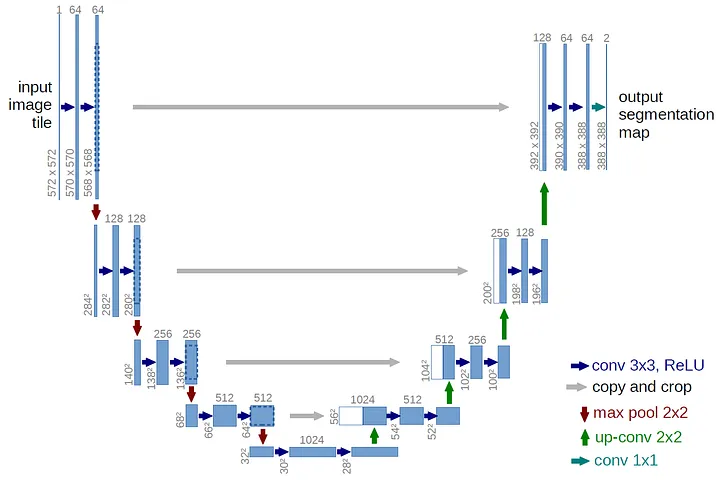

In [26]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Not in the original network
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Not in the original network

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        self.bridge = ConvBlock(512, 1024)

        self.decoder1 = DecoderBlock(1024, 512)
        self.decoder2 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        device = x.device
        s1, p1 = self.encoder1(x.to(device))
        s2, p2 = self.encoder2(p1.to(device))
        s3, p3 = self.encoder3(p2.to(device))
        s4, p4 = self.encoder4(p3.to(device))

        b = self.bridge(p4.to(device))

        d1 = self.decoder1(b.to(device), s4.to(device))
        d2 = self.decoder2(d1.to(device), s3.to(device))
        d3 = self.decoder3(d2.to(device), s2.to(device))
        d4 = self.decoder4(d3.to(device), s1.to(device))

        outputs = torch.sigmoid(self.out_conv(d4.to(device)))  # Binary (can be adapted for multiclass)
        return outputs

In [27]:
def CheckAccuracy(loader, model, name, device='cuda'):
    dice_scores = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1)  # Convert logits to class labels

            # Calculate Dice Score
            intersection = (y_hat * y).sum(dim=(1, 2))
            union = y_hat.sum(dim=(1, 2)) + y.sum(dim=(1, 2))
            dice = (2.0 * intersection) / (union )  # Add epsilon to avoid division by zero
            dice_scores.append(dice.mean().item())



    #print(f"Dice Score of {name}: {dice.mean():.4f}")
    model.train()
    return dice_scores

## Optimización

old

In [10]:
def train_model(dl, model, n_epochs=20, device='cuda'):
    # Optimization
    opt = Adam(model.parameters(), lr=3e-4)  # karpathy's constant
    criterion = nn.CrossEntropyLoss()  # Binary cross-entropy loss with logits

    # Train model
    losses = []
    epochs = []
    accuracy = []
    for epoch in range(n_epochs):
        model.train()
        N = len(dl)

        for i, (x, y) in enumerate(dl):
            x, y = x.to(device), y.to(device).squeeze(1).long()  # Convert mask to [B, H, W] and integer type
            opt.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            opt.step()

            # Store training data
            epochs.append(epoch + i / N)
            losses.append(loss.item())

        print(f"Epoch {epoch + 1}/{n_epochs}, Last Batch Loss: {loss.item():.4f}")
        accuracy.append(CheckAccuracy(train_dl, model, "Train Data", device=device))

    return np.array(epochs), np.array(losses), accuracy

new

In [28]:
def train_model(dl, model, n_epochs=20, device='cuda'):
    # Optimization
    opt = Adam(model.parameters(), lr=3e-4)  # karpathy's constant
    criterion = nn.CrossEntropyLoss()  # Binary cross-entropy loss with logits

    # Initialize progress bar and timing
    start_time = time.time()
    total_steps = n_epochs * len(dl)

    # Train model
    losses = []
    epochs = []
    accuracy = []

    with tqdm(total=total_steps, desc="Training Progress", dynamic_ncols=True, leave=True) as pbar:
        for epoch in range(n_epochs):
            model.train()
            N = len(dl)

            for i, (x, y) in enumerate(dl):
                x, y = x.to(device), y.to(device).squeeze(1).long()  # Convert mask to [B, H, W] and integer type
                opt.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                opt.step()

                # Store training data
                epochs.append(epoch + i / N)
                losses.append(loss.item())

                # Update progress bar
                pbar.update(1)

            # Calculate time left
            elapsed_time = time.time() - start_time
            remaining_steps = total_steps - pbar.n
            time_per_step = elapsed_time / pbar.n if pbar.n > 0 else 0
            estimated_time_left = time_per_step * remaining_steps

            accuracy.append(CheckAccuracy(train_dl, model, "Train Data", device=device))

            # Set progress bar postfix with estimated time left
            pbar.set_postfix({
                "Epoch": f"{epoch + 1}/{n_epochs}",
                "Last Batch Loss": f"{loss.item():.4f}",
                "Accurasy": f"{accuracy[-1][-1]}",
                "Estimated Time Left": f"{int(estimated_time_left // 60)}m {int(estimated_time_left % 60)}s"
            })

    return np.array(epochs), np.array(losses), accuracy

In [29]:
class Report:
    def __init__(self, epoch, loss, Accuracy, type = "Training", n_epochs=20):
        self.epoch = epoch
        self.loss = loss
        self.type = type
        self.n_epochs = n_epochs
        self.Accuracy = torch.tensor(Accuracy, dtype=torch.float32).reshape(-1)
        self.epoch_data_avgd = self.epoch#.reshape(self.n_epochs,-1).mean(axis=1)
        self.loss_data_avgd = self.loss#.reshape(self.n_epochs,-1).mean(axis=1)
    
    def plot_training(self):
        plt.figure(figsize=(5,4))
        plt.plot(self.epoch_data_avgd, self.loss_data_avgd, 'o--', label='Loss', color="Cyan")
        plt.xlabel('Epoch Number')
        plt.ylabel('Cross Entropy')
        plt.title(f'Cross Entropy (avgd per epoch) - {self.type}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(5, 4))
        #plt.plot([i for i in range(1, self.n_epochs + 1)], self.Accuracy, 'd--', label='Accuracy', color='orange')
        plt.plot(self.epoch_data_avgd, self.Accuracy, 'd--', label='Accuracy', color='orange')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy (%)')
        #plt.ylim(min(self.Accuracy)*0.9, 100)
        plt.xlim(0, self.n_epochs)
        plt.title(f'Accuracy Over Epochs - {self.type}')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [30]:
torch.cuda.empty_cache()
model = UNet(in_channels=1, out_channels=2).to(device)
epoch_data, loss_data, Accurasy_data = train_model(train_dl, model, n_epochs=20, device='cuda')

Training Progress: 100%|██████████| 500/500 [01:38<00:00,  5.08it/s, Epoch=20/20, Last Batch Loss=0.3371, Accurasy=0.0, Estimated Time Left=0m 0s]                   


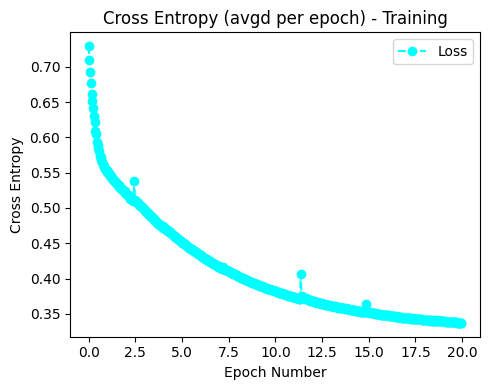

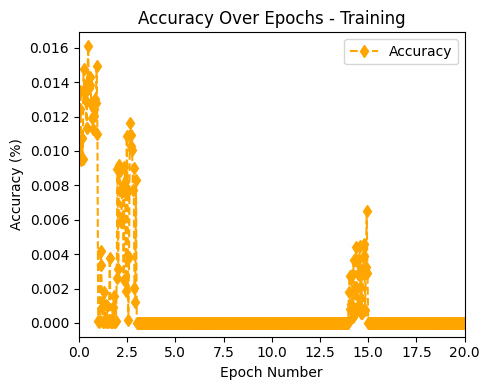

(None, None)

In [31]:
Analisis = Report(epoch_data, loss_data, Accurasy_data,  n_epochs =20)
Analisis.plot_training(), Analisis.plot_accuracy()

In [32]:
acurracy = CheckAccuracy(test_dl, model, "Test Data")

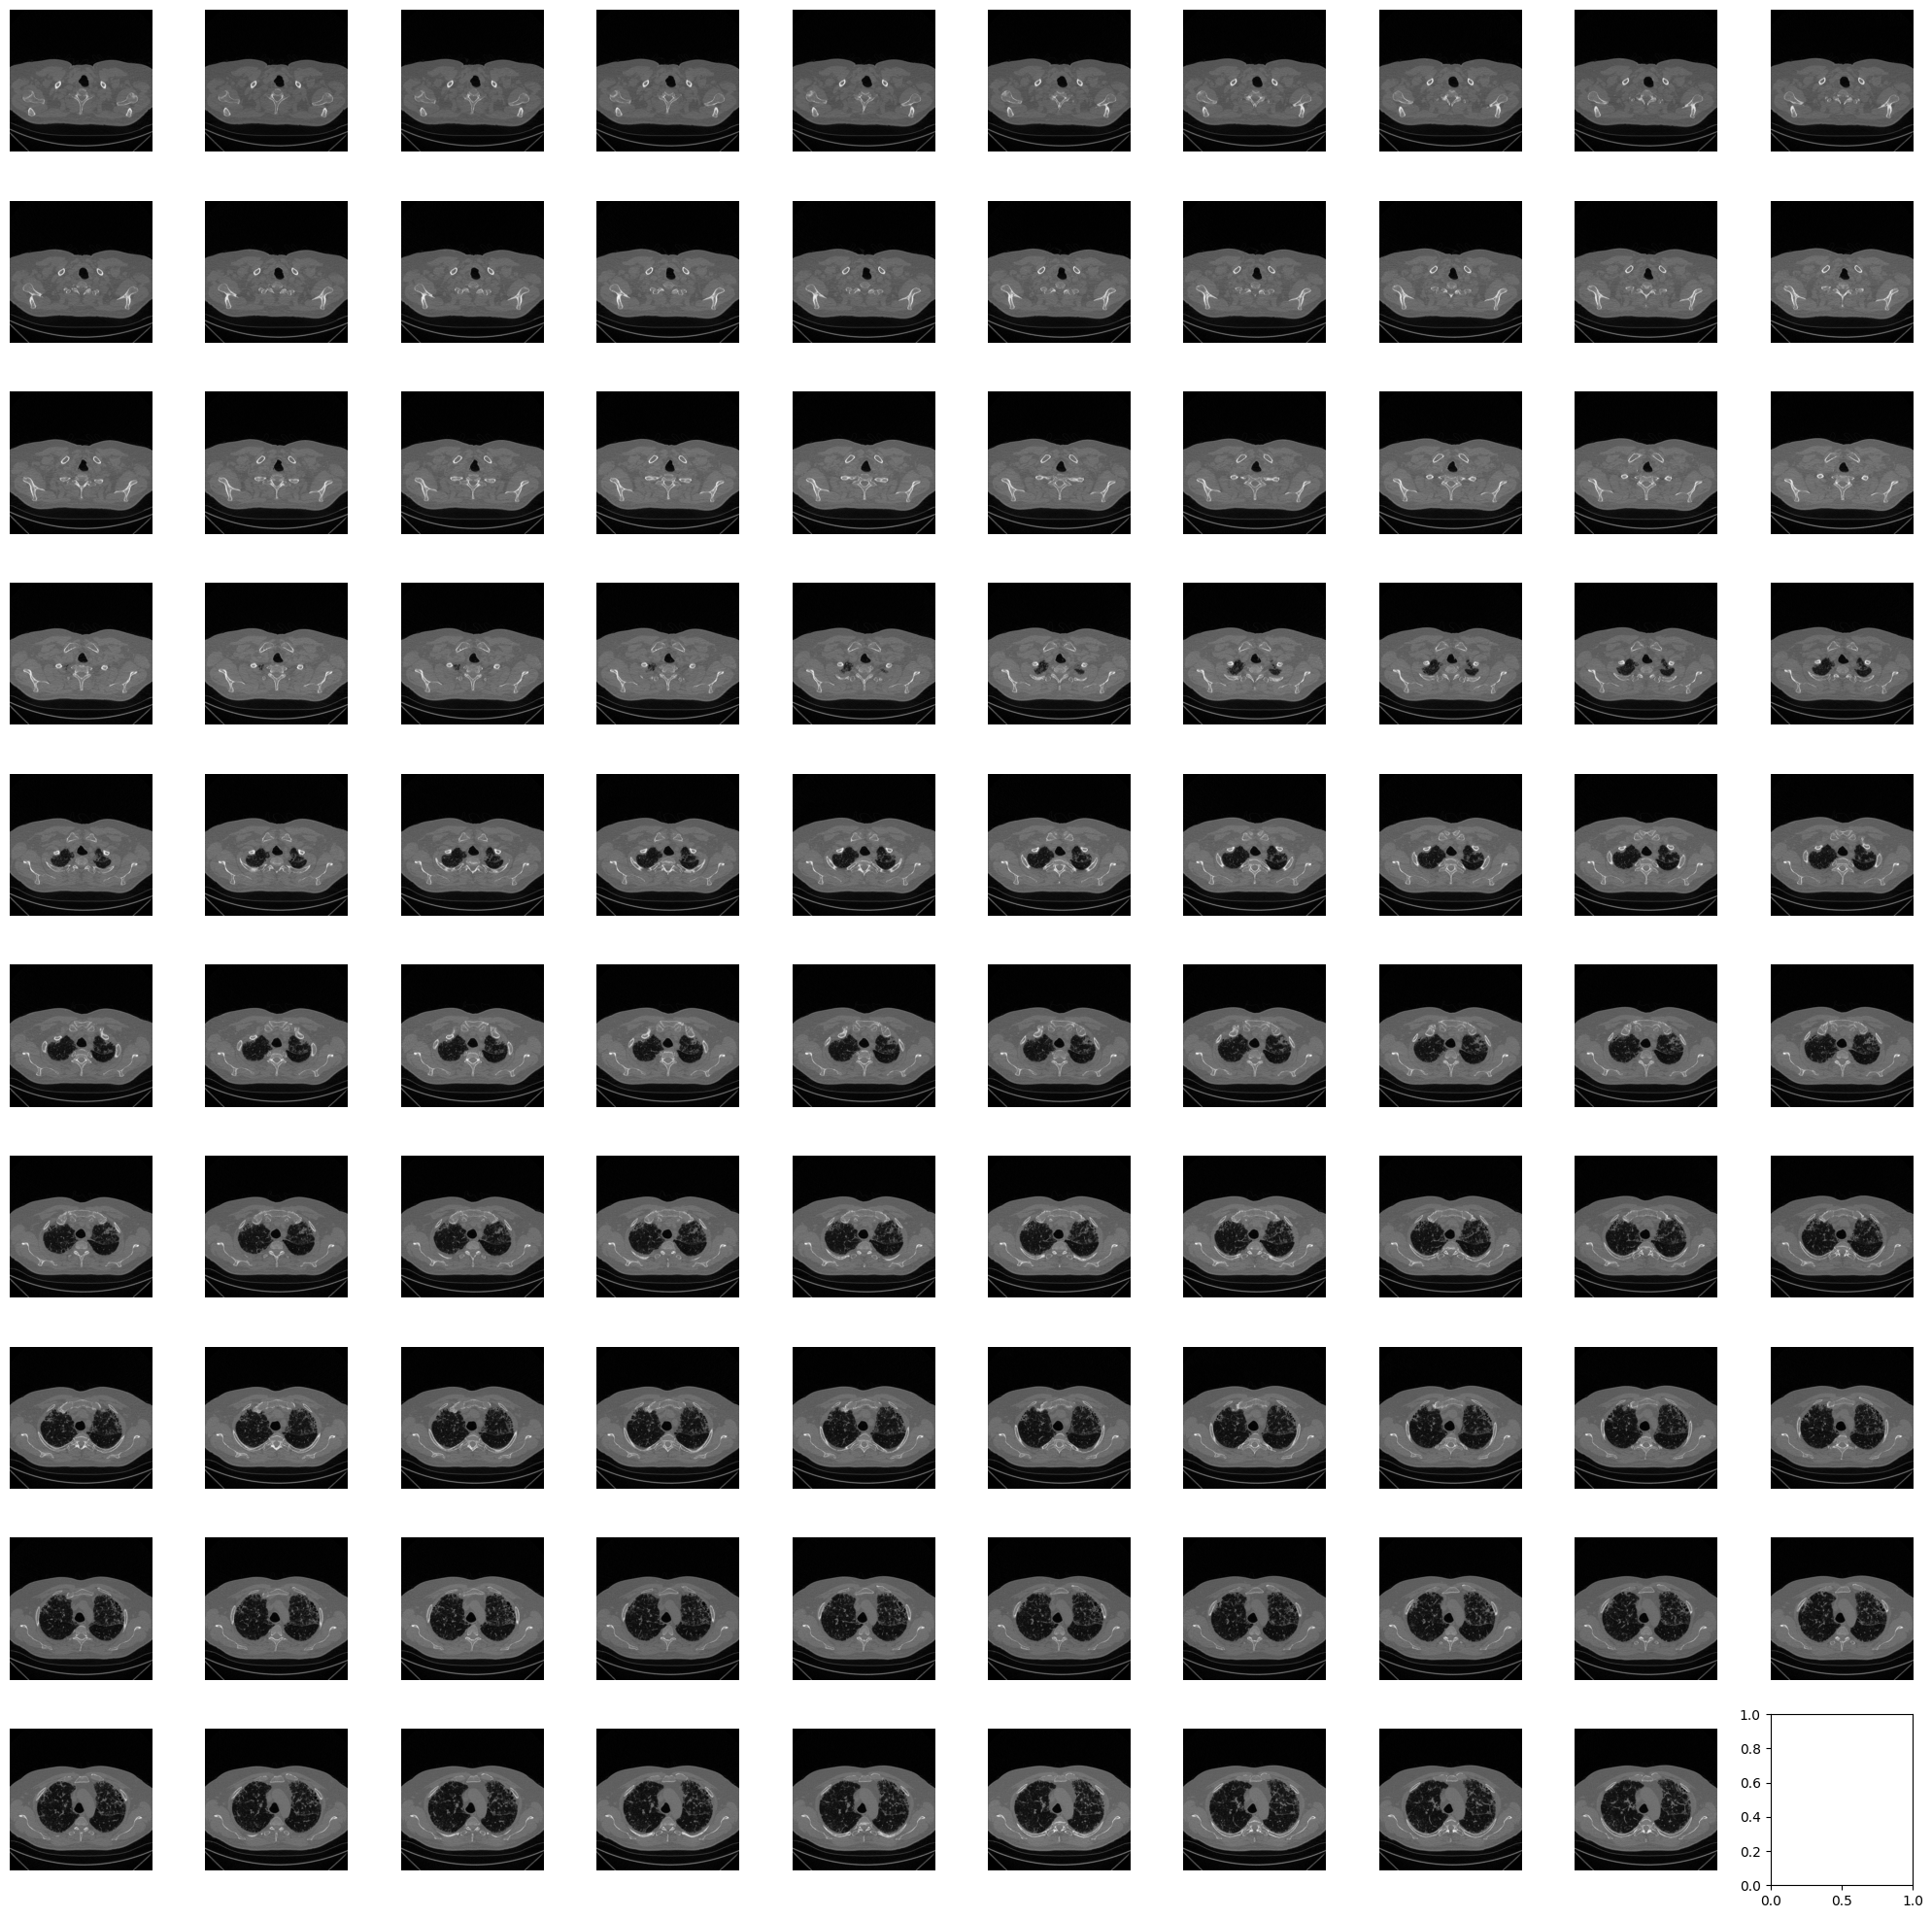

In [33]:

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(1, 100):
    plt.subplot(10, 10, i)
    
    # Move the tensor to CPU and convert it to NumPy for visualization
    
    plt.imshow(train_ds[i], cmap="gray")
    plt.axis("off")
    
fig.tight_layout()
plt.show()

In [38]:
def plot_predictions(model, loader, device='cuda'):
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()  # Convert logits to class labels

            # Plot the first sample in the batch
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
            axes[0].set_title("Input Image")

            axes[1].imshow(y[0].cpu().numpy(), cmap='gray')
            axes[1].set_title("Ground Truth Mask")

            axes[2].imshow(y_hat[0], cmap='gray')
            axes[2].set_title("Predicted Mask")

            plt.show()
            

In [34]:
import matplotlib.pyplot as plt
from ipywidgets import interact
import torch

def plot_predictions_interactive(model, loader, device='cuda'):
    model.eval()
    inputs, ground_truths, predictions = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).squeeze(1)  # Remove channel dimension

            # Model prediction
            y_hat = model(x)
            y_hat = torch.argmax(y_hat, dim=1).cpu().numpy()  # Convert logits to class labels

            # Store data for visualization
            inputs.extend(x[:, 0].cpu().numpy())
            ground_truths.extend(y.cpu().numpy())
            predictions.extend(y_hat)

    def show_sample(idx):
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        axes[0].imshow(inputs[idx], cmap='gray')
        axes[0].set_title("Input Image")
        axes[0].axis('off')

        axes[1].imshow(ground_truths[idx], cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(predictions[idx], cmap='gray')
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.show()

    # Create interactive slider
    interact(show_sample, idx=(0, len(inputs) - 1))

# Example usage:
# plot_predictions_interactive(your_model, your_loader, device='cuda')

In [35]:
plot_predictions_interactive(model, test_dl)

interactive(children=(IntSlider(value=99, description='idx', max=199), Output()), _dom_classes=('widget-intera…